Mushrooms can be either toxic or edible. It takes trained mushroom hunters and mycologists to discern the toxic mushrooms from the edible mushrooms. Can machine learning algorithms also classify the edibility of mushrooms? We'll visualize some of the data here, to get an idea of how the data is related, and then implement several different classifiers on the dataset.

This might go without saying, but don't take advice about which mushrooms to eat from an IPython notebook. I do not condone eating any mushrooms based on the patterns revealed in this notebook or in the accompanying Python script or documentation.

To start with, we'll import all the necessry modules that we need. 

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report, log_loss
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")

We'll load in the data for the mushrooms. Then we need to check if there is any null data in the dataset. There are only two classes: edible and poisonous. We can confirm that this is the case by printing the unique values of the class feature. We're going to need to encode non-numerical data, that is, transform it into a form that our classifiers can use. Scikit-Learn has a Label Encoder that will represent our non-numerical values as numerical ones. So we'll create an instance of the encoder and then apply the transformation to every column in the dataset. We can print out the dataframe to be sure that there the transformations have been correct.

In [2]:
m_data = pd.read_csv('mushrooms.csv')

# check for any null values
print(m_data.isnull().sum())

# see all unique values in a category
print(m_data['class'].unique())

# machine learning systems work with integers, we need to encode these
# string characters into ints

encoder = LabelEncoder()
# now apply the transformation to all the columns:
for col in m_data.columns:
    m_data[col] = encoder.fit_transform(m_data[col])

print(m_data.head(5))

class                       0
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-root                  0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-type                   0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64
['p' 'e']
   class  cap-shape  cap-surface  cap-color  bruises  odor  gill-attachment  \
0      1          5            2          4        1     6                1   
1      0          5            2          9        1     0                1   
2      0          0            2          8       

Now we can do some plotting of the data. Let's do a heatmap plot, which compares the correlation of every feature with every other feature.

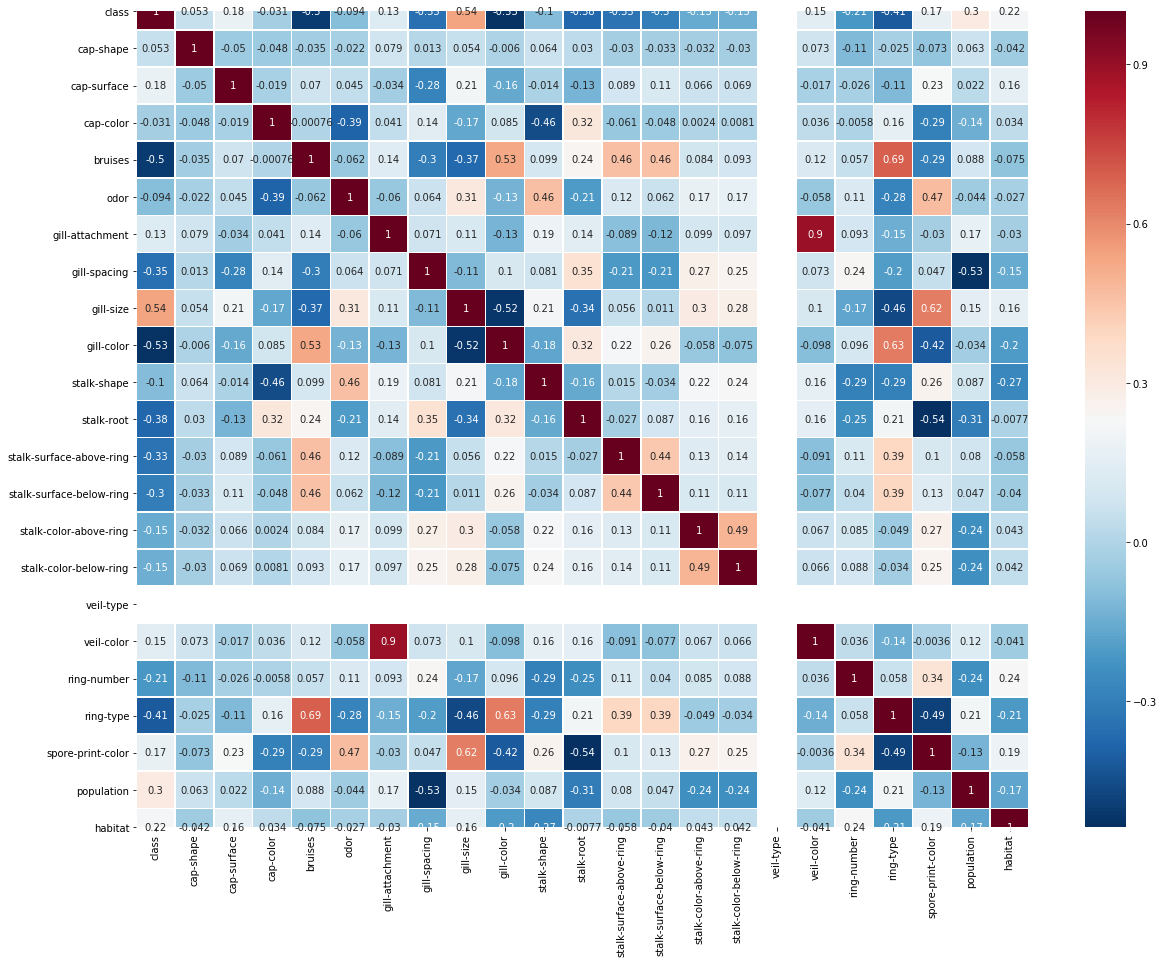

In [3]:
# let's see how many poisonous and edible there are of each, 1 is poisonous, 0 is edible
# check to get a rough idea of correlations
correlations = m_data.corr()
plt.subplots(figsize=(20, 15))
#plt.figure(figsize=(16, 14))
data_corr = sns.heatmap(correlations, annot=True, linewidths=0.5, cmap="RdBu_r")
plt.show(data_corr)

It looks like the features most closely associated with class are: cap-surface, gill-attachment, gill-size, veil-color, spore-print-color, population, and habitat. Why don't we see if we can plot the correlations of those variables individually.

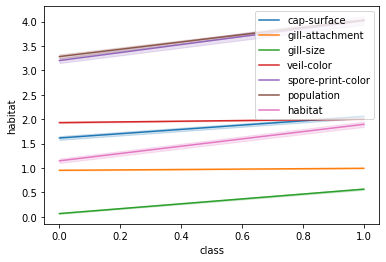

In [4]:
features = ["cap-surface", "gill-attachment", "gill-size", "veil-color", "spore-print-color", "population", "habitat"]

for feature in features:
    line_plot = sns.lineplot(x="class", y=feature, label=feature, data=m_data)
    
plt.legend(loc=1)    
plt.show()

If we are so inclined, we can chart how individual attributes are likely to correlate with a mushroom's likelihood of beind poisonous. We just get the individual colors stored in the "gill-color" feature and we plot them against class. We need to specify the names of the gill-colors and choose colors to represent them in our plot, however.

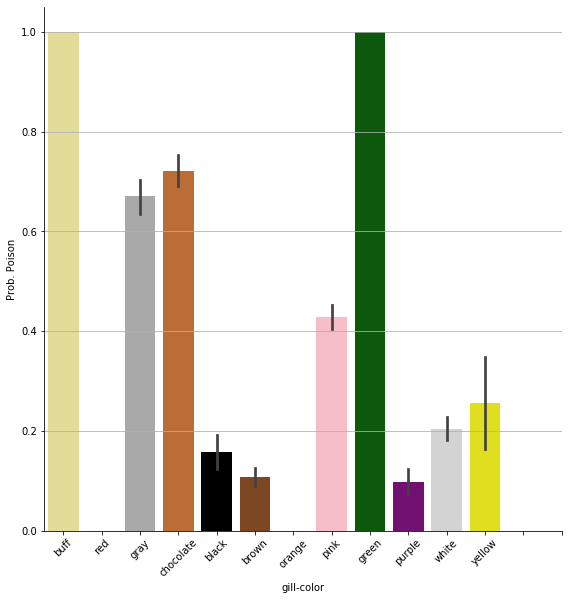

In [5]:
gill_names =["buff", "red", "gray", "chocolate", "black", "brown", "orange", "pink", "green", "purple", "white", "yellow"]
gill_colors = ["khaki", "Red", "darkGrey", "chocolate", "Black", "saddleBrown", "orange", "lightpink", "darkGreen", "purple", "lightGrey", "Yellow"]

factor = sns.factorplot(x="gill-color",y="class",data=m_data, kind="bar", size = 8,
palette = gill_colors)
factor.set_xticklabels(rotation=45)
factor.set(xticks=range(0,14), xticklabels=gill_names)
factor = factor.set_ylabels("Prob. Poison")
plt.grid(axis='y')
plt.show()

Now we need to split our data into features and labels. This is easy because the "class" feature is the first in the dataframe, so all we need to do is cast the features as everything but the first column and do the opposite for the labels. We'll also want to scale the data. Scaling our data is important as the data covers a wide range. The sheer range of the data can throw off the accuracy of our classifier, so by standardizing the data we make sure our classifier performs optimally. We'll create an instance of the classifier and then transform the data with it. We don't need to scale the labels/targets as they are only 0 or 1.

In [6]:
X_features = m_data.iloc[:,1:23]  
y_label = m_data.iloc[:, 0]  
#let's confirm we're slicing this right
print(X_features.head())
print(y_label.head())
print(X_features.describe)

# we should probably scale the features, so that SVM or gaussian NB can deliver better predictions
scaler = StandardScaler()
X_features = scaler.fit_transform(X_features)

   cap-shape  cap-surface  cap-color  bruises  odor  gill-attachment  \
0          5            2          4        1     6                1   
1          5            2          9        1     0                1   
2          0            2          8        1     3                1   
3          5            3          8        1     6                1   
4          5            2          3        0     5                1   

   gill-spacing  gill-size  gill-color  stalk-shape  ...  \
0             0          1           4            0  ...   
1             0          0           4            0  ...   
2             0          0           5            0  ...   
3             0          1           5            0  ...   
4             1          0           4            1  ...   

   stalk-surface-below-ring  stalk-color-above-ring  stalk-color-below-ring  \
0                         2                       7                       7   
1                         2                     

Principal Component Analysis is a method that can simplify the representation of features, distilling the most important features down into a combination of just a few features. PCA can help improve the outcome of a classifier. However, PCA works best when datasets are large, and since this dataset is relatively small, we may not want to do it. We can plot the conclusions of the PCA to see what kind of dimensions the data would be compressed to.

We fit the PCA on our features and plot the explained variance ratio. The explained variance ratio is a way of measuring how many features describe a given portion of the data. We can plot our this function to get an idea of how many features are needed to describe 90% or 100% of the data. Let's plot the ratio.

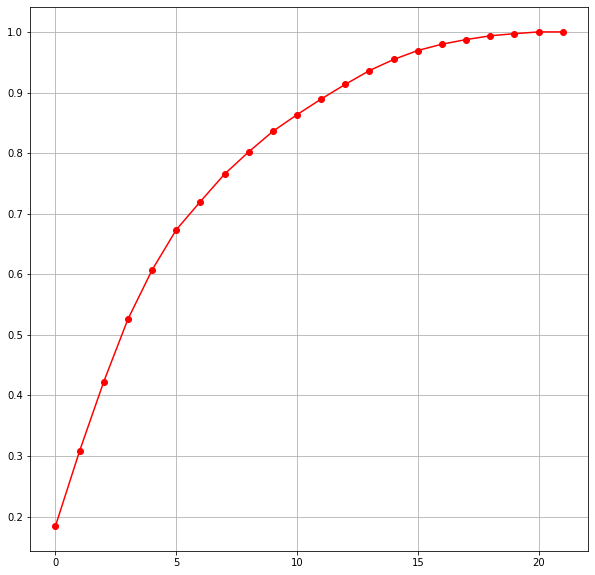

In [7]:
# principal component analysis, may or may not want to do, small dataset
pca = PCA()
pca.fit_transform(X_features)
plt.figure(figsize=(10,10))
# plot the explained variance ratio
plt.plot(np.cumsum(pca.explained_variance_ratio_), 'ro-')
plt.grid()
plt.show()
# it looks like about 17 of the features account for about 95% of the variance in the dataset

Here's another way that the explained variance can be plotted. Plotting it like this leads to the same conclusion: around 18 features describe 99% of the dataset.

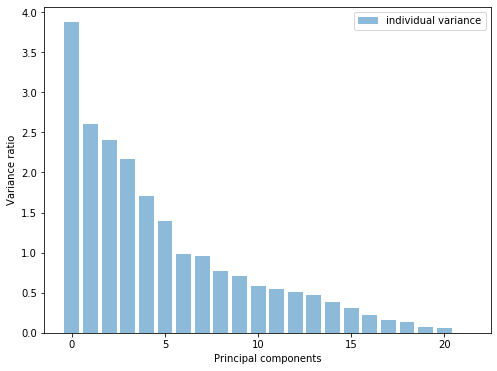

In [8]:
# here's another way to visualize this
pca_variance = pca.explained_variance_

plt.figure(figsize=(8, 6))
plt.bar(range(22), pca_variance, alpha=0.5, align='center', label='individual variance')
plt.legend()
plt.ylabel('Variance ratio')
plt.xlabel('Principal components')
plt.show()

Let's go ahead and create a new PCA object and use 17 or 18 features to comprise our new featureset.

In [9]:
pca2 = PCA(n_components=17)
x_new = pca2.fit_transform(X_features)
X_train, X_test, y_train, y_test = train_test_split(x_new, y_label, test_size=0.20, random_state=2)

Now we can select our chosen classifiers and run GridSearchCV to find their best possible parameters. GridSearchCV takes a specified list of parameters and tests the classifier with the potential combinatiosn of your schosen parameters to see which combination is best. Doing this should dramatically improve the performance of our classifiers compared to just implementing them vanilla. We have to fit GridSearchCV on the classifiers and our chosen parameters, and then save the optimized settings as a new instance of the classifier.

In [10]:
logreg_clf = LogisticRegression()
parameters_logreg = {"penalty": ["l2"], "solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
                     "max_iter": [25, 50, 100, 200, 400]}
grid_logreg = GridSearchCV(logreg_clf, parameters_logreg)
grid_logreg.fit(X_train, y_train)
logreg_opt = grid_logreg.best_estimator_

GNB_clf = GaussianNB()
GNB_clf.fit(X_train, y_train)

svc_clf = SVC()
svc_param = {"kernel": ["rbf", "linear"]}
grid_svc = GridSearchCV(svc_clf, svc_param)
grid_svc.fit(X_train, y_train)
svc_opt = grid_svc.best_estimator_

rf_clf = RandomForestClassifier()
parameters_rf = {"n_estimators": [4, 6, 8, 10, 12, 14, 16], "criterion": ["gini", "entropy"], "max_features": ["auto", "sqrt", "log2"],
                 "max_depth": [2, 3, 5, 10], "min_samples_split": [2, 3, 5, 10]}
grid_rf = GridSearchCV(rf_clf, parameters_rf)
grid_rf.fit(X_train, y_train)
rf_opt = grid_rf.best_estimator_

knn_clf = KNeighborsClassifier()
parameters_knn = {"n_neighbors": [3, 5, 10, 15, 20], "weights": ["uniform", "distance"],
                  "leaf_size": [10, 20, 30, 45, 60]}
grid_knn = GridSearchCV(knn_clf, parameters_knn)
grid_knn.fit(X_train, y_train)
knn_opt = grid_knn.best_estimator_

dt_clf = DecisionTreeClassifier()
parameters_dt = {"criterion": ["gini", "entropy"], "splitter": ["best", "random"], "max_features": ["auto", "log2", "sqrt"]}
grid_dt = GridSearchCV(dt_clf, parameters_dt)
grid_dt.fit(X_train, y_train)
dt_opt = grid_dt.best_estimator_

xgb_clf = XGBClassifier()
parameters_xg = {"objective" : ["reg:linear"], "n_estimators" : [5, 10, 15, 20]}
grid_xg = GridSearchCV(xgb_clf, parameters_xg)
grid_xg.fit(X_train, y_train)
xgb_opt = grid_xg.best_estimator_

chosen_metrics = [accuracy_score, log_loss, classification_report]

[06:39:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:39:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:39:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:39:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:39:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:39:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:39:20] WARNI

Finally, we can create a function to do the classification and return our chosen metrics.

In [11]:
def get_reports(metrics, classifier):

    preds = classifier.predict(X_test)
    print("'{}' Performance: ".format(classifier.__class__.__name__))
    acc = accuracy_score(y_test, preds)
    l_loss = log_loss(y_test, preds)
    c_report = classification_report(y_test, preds)
    print("Accuracy: " + str(acc))
    print("Log Loss: " + str(l_loss))
    print("Classificaiton Report: ")
    print(c_report)
    print("----------")

get_reports(chosen_metrics, logreg_opt)
get_reports(chosen_metrics, GNB_clf)
get_reports(chosen_metrics, svc_opt)
get_reports(chosen_metrics, rf_opt)
get_reports(chosen_metrics, knn_opt)
get_reports(chosen_metrics, dt_opt)
get_reports(chosen_metrics, xgb_opt)

'LogisticRegression' Performance: 
Accuracy: 0.9427692307692308
Log Loss: 1.9766989475886843
Classificaiton Report: 
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       860
           1       0.95      0.93      0.94       765

    accuracy                           0.94      1625
   macro avg       0.94      0.94      0.94      1625
weighted avg       0.94      0.94      0.94      1625

----------
'GaussianNB' Performance: 
Accuracy: 0.9298461538461539
Log Loss: 2.423050640308682
Classificaiton Report: 
              precision    recall  f1-score   support

           0       0.92      0.95      0.93       860
           1       0.94      0.91      0.92       765

    accuracy                           0.93      1625
   macro avg       0.93      0.93      0.93      1625
weighted avg       0.93      0.93      0.93      1625

----------
'SVC' Performance: 
Accuracy: 1.0
Log Loss: 9.992007221626413e-16
Classificaiton Report: 
         